# Checking differences in NO$_3$ with the World Ocean Atlas from 1981 to 2010 - so a bit longer than this time series

In [1]:
import warnings
warnings.simplefilter("ignore") # Silence warnings
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import numpy as np
from matplotlib.pyplot import figure
import numpy.ma as ma
from netCDF4 import Dataset as NetCDFFile
import glob
import cartopy
import cartopy.crs as ccrs
import pylab 
from copy import deepcopy
import pandas as pd
import matplotlib
import matplotlib.colors as colors
from cartopy.util import add_cyclic_point
import matplotlib.gridspec as gridspec
plt.rcParams['mathtext.default']='regular'
from collections import OrderedDict
import cmocean
import matplotlib.cm as cm
import matplotlib as mpl
import seaborn as sns

In [2]:
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        if clip is None:
            clip = self.clip

        result, is_scalar = self.process_value(value)

        self.autoscale_None(result)
        vmin, vmax, midpoint = self.vmin, self.vmax, self.midpoint

        if not (vmin < midpoint < vmax):
            raise ValueError("midpoint must be between maxvalue and minvalue.")
        elif vmin == vmax:
            result.fill(0) # Or should it be all masked? Or 0.5?
        elif vmin > vmax:
            raise ValueError("maxvalue must be bigger than minvalue")
        else:
            vmin = float(vmin)
            vmax = float(vmax)
            if clip:
                mask = np.ma.getmask(result)
                result = np.ma.array(np.clip(result.filled(vmax), vmin, vmax),
                                  mask=mask)

            # ma division is very slow; we can take a shortcut
            resdat = result.data

            #First scale to -1 to 1 range, than to from 0 to 1.
            resdat -= midpoint
            resdat[resdat>0] /= abs(vmax - midpoint)
            resdat[resdat<0] /= abs(vmin - midpoint)

            resdat /= 2.
            resdat += 0.5
            result = np.ma.array(resdat, mask=result.mask, copy=False)

        if is_scalar:
            result = result[0]
        return result

# input file

In [3]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

## World Ocean Atlas NO$_3$ 
    - n01_01.nc - January
    - n02_01.nc - February
    - n03_01.nc - March
    - n04_01.nc - April
    - n05_01.nc - May 
    - n06_01.nc - June
    - n07_01.nc - July
    - n08_01.nc - August 
    - n09_01.nc - September 
    - n10_01.nc - October 
    - n11_01.nc - November 
    - n12_01.nc - December 
    - woa18_all_n00_01.nc - Annual 

path = '/glade/derecho/scratch/gabyn/obs/NO3/'
ds_01 = xr.open_mfdataset(f'{path}woa18_all_n01_01.nc',decode_times=False)
ds_02 = xr.open_mfdataset(f'{path}woa18_all_n02_01.nc',decode_times=False)
ds_03 = xr.open_mfdataset(f'{path}woa18_all_n03_01.nc',decode_times=False)
ds_04 = xr.open_mfdataset(f'{path}woa18_all_n04_01.nc',decode_times=False)
ds_05 = xr.open_mfdataset(f'{path}woa18_all_n05_01.nc',decode_times=False)
ds_06 = xr.open_mfdataset(f'{path}woa18_all_n06_01.nc',decode_times=False)
ds_07 = xr.open_mfdataset(f'{path}woa18_all_n07_01.nc',decode_times=False)
ds_08 = xr.open_mfdataset(f'{path}woa18_all_n08_01.nc',decode_times=False)
ds_09 = xr.open_mfdataset(f'{path}woa18_all_n09_01.nc',decode_times=False)
ds_10 = xr.open_mfdataset(f'{path}/woa18_all_n10_01.nc',decode_times=False)
ds_11 = xr.open_mfdataset(f'{path}woa18_all_n11_01.nc',decode_times=False)
ds_12 = xr.open_mfdataset(f'{path}woa18_all_n12_01.nc',decode_times=False)

In [4]:
ds_all = xr.open_mfdataset('/glade/derecho/scratch/gabyn/obs/NO3/woa18_all_n00_01.nc',decode_times=False)

	NC4_open: path /glade/derecho/scratch/gabyn/obs/NO3/woa18_all_n00_01.nc mode 4096 params 0
	HDF5 error messages turned on.
			nc4_open_file: path /glade/derecho/scratch/gabyn/obs/NO3/woa18_all_n00_01.nc mode 4096
			nc4_grp_list_add: name / 
			nc4_rec_read_metadata: grp->hdr.name /
			found dataset nbounds
			found dataset crs
			found dataset lat
			found dataset lat_bnds
			found dataset lon
			found dataset lon_bnds
			found dataset depth
			found dataset depth_bnds
			found dataset time
			found dataset climatology_bounds
			found dataset n_an
			found dataset n_mn
			found dataset n_dd
			found dataset n_sd
			found dataset n_se
			found dataset n_oa
			found dataset n_gp
ERROR: Invalid _NCProperties attribute
		*** NetCDF-4 Internal Metadata: int_ncid 0x10000 ext_ncid 0x10000
		FILE - path: /glade/derecho/scratch/gabyn/obs/NO3/woa18_all_n00_01.nc cmode: 0x1108 parallel: 0 redef: 0 fill_mode: 0 no_write: 1 next_nc_grpid: 1
		 GROUP - / nc_grpid: 0 nvars: 16 natts: 0
		 DIMENSION

In [5]:
### First 20 year climatology GNG595
file = '/glade/derecho/scratch/gabyn/SPECTRA_hindcast/SPECTRA_1990_2009/GNG595_2ndcycle_1990-2009_clim/regrid'
newNCDFfiles1 = sorted(glob.glob(f'{file}/regrid_GNG595_NO3.*.nc', recursive=True),
                      key=numericalSort)

ds = xr.open_mfdataset(newNCDFfiles1,concat_dim='time', combine='nested')

standard_name
			nc4_get_att: ncid 0x10000 varid 10 name standard_name attnum -1 mem_type 0
			nc4_get_att: ncid 0x10000 varid 10 name standard_name attnum -1 mem_type 2
		NC4_inq_att: ncid 0x10000 varid 10 name long_name
			nc4_get_att: ncid 0x10000 varid 10 name long_name attnum -1 mem_type 0
			nc4_get_att: ncid 0x10000 varid 10 name long_name attnum -1 mem_type 2
		NC4_inq_att: ncid 0x10000 varid 10 name coordinates
			nc4_get_att: ncid 0x10000 varid 10 name coordinates attnum -1 mem_type 0
			nc4_get_att: ncid 0x10000 varid 10 name coordinates attnum -1 mem_type 2
		NC4_inq_att: ncid 0x10000 varid 10 name cell_methods
			nc4_get_att: ncid 0x10000 varid 10 name cell_methods attnum -1 mem_type 0
			nc4_get_att: ncid 0x10000 varid 10 name cell_methods attnum -1 mem_type 2
		NC4_inq_att: ncid 0x10000 varid 10 name grid_mapping
			nc4_get_att: ncid 0x10000 varid 10 name grid_mapping attnum -1 mem_type 0
			nc4_get_att: ncid 0x10000 varid 10 name grid_mapping attnum -1 mem_type 2
		NC4_

# To convert $\frac{umol}{kg}$ to $\frac{mmol}{m^3}$ 
$\frac{umol}{kg} * \frac{1 mmol}{1000 umol} * \frac{1026 kg}{1 m^3} = 0.97465 \frac{mmol}{m^3} $

In [6]:
NO3_woa_10m = np.nansum(ds_all.n_an[:,0:3,:,:],axis=(0,1)) *0.97465 # Sum through the top 10m, which is the surface layer in spectra. (umol/kg ---> mmol/m3)

		NC4_inq_var_all: ncid 0x10000 varid 9
		NC4_inq_var_all: ncid 0x10000 varid 9
		NC4_inq_dim: ncid 0x10000 dimid 4
		NC4_inq_dim: ncid 0x10000 dimid 3
		NC4_inq_dim: ncid 0x10000 dimid 1
		NC4_inq_dim: ncid 0x10000 dimid 2
		NC4_inq_dim: ncid 0x10000 dimid 4
		NC4_inq_dim: ncid 0x10000 dimid 3
		NC4_inq_dim: ncid 0x10000 dimid 1
		NC4_inq_dim: ncid 0x10000 dimid 2
		NC4_inq_var_all: ncid 0x10000 varid 9
		NC4_inq_var_all: ncid 0x10000 varid 9
		NC4_inq_dim: ncid 0x10000 dimid 4
		NC4_inq_dim: ncid 0x10000 dimid 3
		NC4_inq_dim: ncid 0x10000 dimid 1
		NC4_inq_dim: ncid 0x10000 dimid 2
		NC4_inq_var_all: ncid 0x10000 varid 9
		NC4_inq_var_all: ncid 0x10000 varid 9
		NC4_inq_dim: ncid 0x10000 dimid 4
		NC4_inq_dim: ncid 0x10000 dimid 3
		NC4_inq_dim: ncid 0x10000 dimid 1
		NC4_inq_dim: ncid 0x10000 dimid 2
		NC4_inq_var_all: ncid 0x10000 varid 9
			NC4_get_vars: var->hdr.name n_an mem_nc_type 5
		NC4_inq_var_all: ncid 0x10000 varid 9
		NC4_inq_var_all: ncid 0x10000 varid 9
		NC4_inq_dim:

In [7]:
surface_NO3_woa = ds_all.n_an[0,0,:,:] *0.97465 # Sum through the top 10m, which is the surface layer in spectra. (umol/kg ---> mmol/m3)

In [8]:
surface_NO3_woa.shape

(180, 360)

In [9]:
surface_NO3_SPECTRA = np.nanmean(ds.NO3[:,0,:,:],axis=0) # mmol/m^3

In [10]:
surface_NO3_SPECTRA.shape

(180, 360)

In [11]:
ds_all.lon

<xarray.DataArray 'lon' (lon: 360)>
array([-179.5, -178.5, -177.5, ...,  177.5,  178.5,  179.5], dtype=float32)
Coordinates:
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Attributes:
    standard_name:  longitude
    long_name:      longitude
    units:          degrees_east
    axis:           X
    bounds:         lon_bnds

		NC4_inq_var_all: ncid 0x10000 varid 9
		NC4_inq_var_all: ncid 0x10000 varid 9
		NC4_inq_dim: ncid 0x10000 dimid 4
		NC4_inq_dim: ncid 0x10000 dimid 3
		NC4_inq_dim: ncid 0x10000 dimid 1
		NC4_inq_dim: ncid 0x10000 dimid 2
		NC4_inq_dim: ncid 0x10000 dimid 4
		NC4_inq_dim: ncid 0x10000 dimid 3
		NC4_inq_dim: ncid 0x10000 dimid 1
		NC4_inq_dim: ncid 0x10000 dimid 2
		NC4_inq_var_all: ncid 0x10000 varid 9
		NC4_inq_var_all: ncid 0x10000 varid 9
		NC4_inq_dim: ncid 0x10000 dimid 4
		NC4_inq_dim: ncid 0x10000 dimid 3
		NC4_inq_dim: ncid 0x10000 dimid 1
		NC4_inq_dim: ncid 0x10000 dimid 2
		NC4_inq_var_all: ncid 0x10000 varid 9
		NC4_inq_var_all: ncid 0x10000 varid 9
		NC4_inq_dim: ncid 0x10000 dimid 4
		NC4_inq_dim: ncid 0x10000 dimid 3
		NC4_inq_dim: ncid 0x10000 dimid 1
		NC4_inq_dim: ncid 0x10000 dimid 2
		NC4_inq_var_all: ncid 0x10000 varid 9
			NC4_get_vars: var->hdr.name n_an mem_nc_type 5
		NC4_inq_var_all: ncid 0x10000 varid 9
		NC4_inq_var_all: ncid 0x10000 varid 9
		NC4_inq_dim:

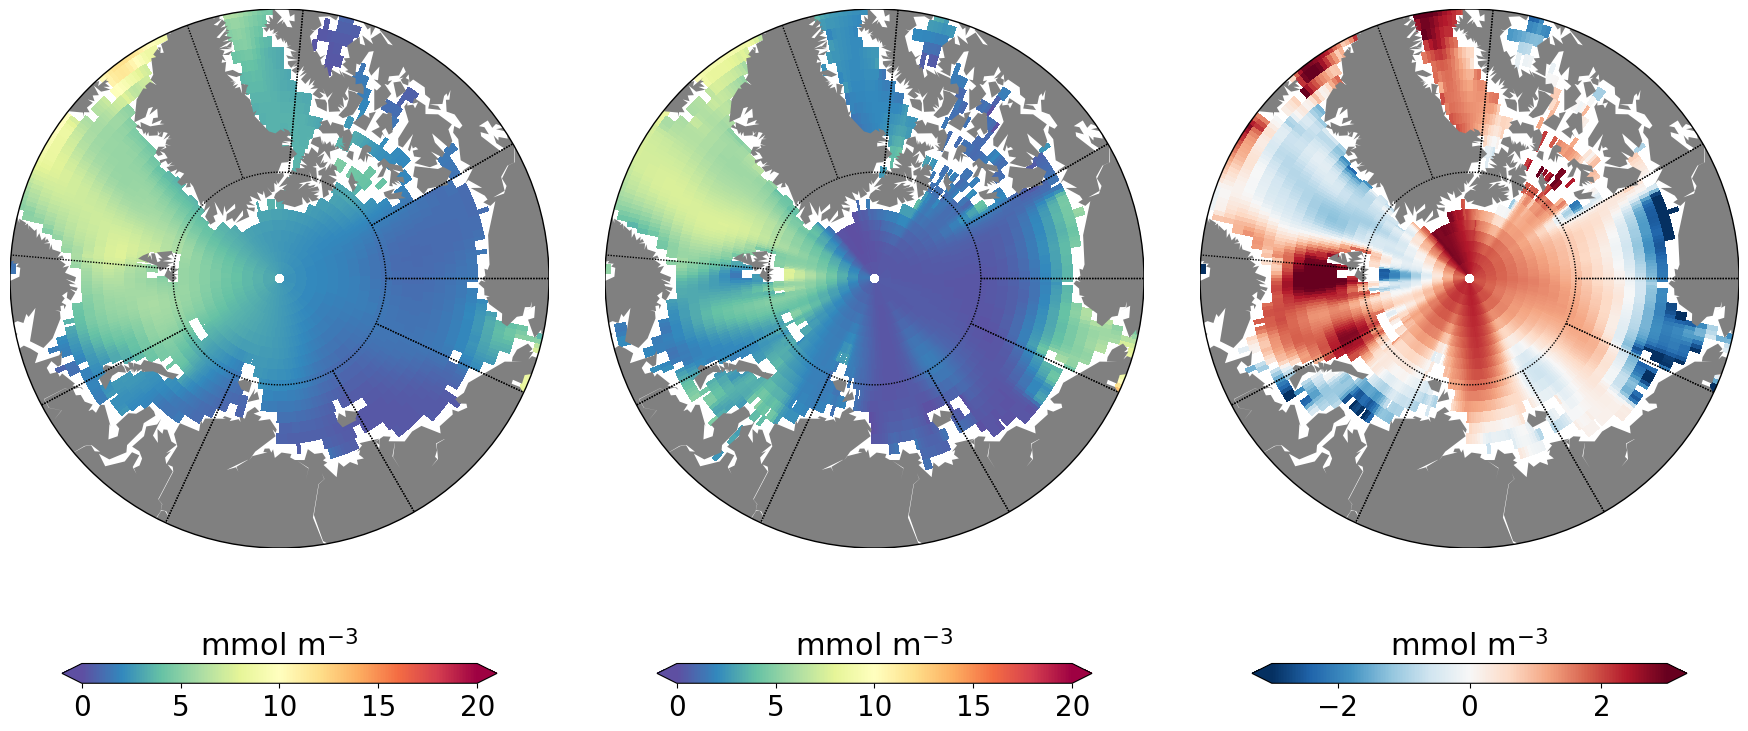

In [13]:
from mpl_toolkits.basemap import Basemap
fig = plt.figure(figsize=(18, 8))
lat = ds.lat
vminn=0
vmaxx=20
ax = fig.add_subplot(1, 3, 1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
model, lon = add_cyclic_point(surface_NO3_SPECTRA, coord=ds.lon, axis=1)
x, y = m(*np.meshgrid(lon,ds.lat))
cf = m.pcolor(x,y,model,cmap='Spectral_r', vmin=vminn, vmax=vmaxx)
cb = plt.colorbar(cf, shrink=0.75, orientation='horizontal',extend = 'both')
cb.ax.set_title('mmol m$^{-3}$', fontsize = 22)
cb.ax.tick_params(labelsize=20)
ax.set_title('', fontsize =20)

m.drawmeridians((180,205), color='k', linewidth=1.0, zorder=None, dashes=[1, 1])
m.drawmeridians((205,235), color='k', linewidth=1.0, zorder=None, dashes=[1, 1])
m.drawmeridians((235,290), color='k', linewidth=1.0, zorder=None, dashes=[1, 1])
m.drawmeridians((290,315), color='k', linewidth=1.0, zorder=None, dashes=[1, 1])
m.drawmeridians((145,180), color='k', linewidth=1.0, zorder=None, dashes=[1, 1])
m.drawmeridians((90,145), color='k', linewidth=1.0, zorder=None, dashes=[1, 1])
m.drawmeridians((53,90), color='k', linewidth=1.0, zorder=None, dashes=[1, 1])
m.drawmeridians((20,53), color='k', linewidth=1.0, zorder=None, dashes=[1, 1])
m.drawparallels((60,90), color='k', linewidth=1.0, zorder=None, dashes=[1, 1])

ax = fig.add_subplot(1, 3, 2)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
obs, lon = add_cyclic_point(surface_NO3_woa, coord=ds.lon, axis=1)
x, y = m(*np.meshgrid(lon,ds.lat))
cf = m.pcolor(x,y,obs,cmap='Spectral_r', vmin=vminn, vmax=vmaxx)
cb = plt.colorbar(cf, shrink=0.75, orientation='horizontal',extend = 'both')
cb.ax.set_title('mmol m$^{-3}$', fontsize = 22)
cb.ax.tick_params(labelsize=20)
ax.set_title('', fontsize =20)

m.drawmeridians((180,205), color='k', linewidth=1.0, zorder=None, dashes=[1, 1])
m.drawmeridians((205,235), color='k', linewidth=1.0, zorder=None, dashes=[1, 1])
m.drawmeridians((235,290), color='k', linewidth=1.0, zorder=None, dashes=[1, 1])
m.drawmeridians((290,315), color='k', linewidth=1.0, zorder=None, dashes=[1, 1])
m.drawmeridians((145,180), color='k', linewidth=1.0, zorder=None, dashes=[1, 1])
m.drawmeridians((90,145), color='k', linewidth=1.0, zorder=None, dashes=[1, 1])
m.drawmeridians((53,90), color='k', linewidth=1.0, zorder=None, dashes=[1, 1])
m.drawmeridians((20,53), color='k', linewidth=1.0, zorder=None, dashes=[1, 1])
m.drawparallels((60,90), color='k', linewidth=1.0, zorder=None, dashes=[1, 1])

ax = fig.add_subplot(1, 3, 3)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x,y,model-obs,cmap='RdBu_r', vmin = -3, vmax = 3)
cb = plt.colorbar(cf, shrink=0.75, orientation='horizontal',extend = 'both')
cb.ax.set_title('mmol m$^{-3}$', fontsize = 22)
cb.ax.tick_params(labelsize=20)
ax.set_title('', fontsize =20)

m.drawmeridians((180,205), color='k', linewidth=1.0, zorder=None, dashes=[1, 1])
m.drawmeridians((205,235), color='k', linewidth=1.0, zorder=None, dashes=[1, 1])
m.drawmeridians((235,290), color='k', linewidth=1.0, zorder=None, dashes=[1, 1])
m.drawmeridians((290,315), color='k', linewidth=1.0, zorder=None, dashes=[1, 1])
m.drawmeridians((145,180), color='k', linewidth=1.0, zorder=None, dashes=[1, 1])
m.drawmeridians((90,145), color='k', linewidth=1.0, zorder=None, dashes=[1, 1])
m.drawmeridians((53,90), color='k', linewidth=1.0, zorder=None, dashes=[1, 1])
m.drawmeridians((20,53), color='k', linewidth=1.0, zorder=None, dashes=[1, 1])
m.drawparallels((60,90), color='k', linewidth=1.0, zorder=None, dashes=[1, 1])
fig.tight_layout()
fig.savefig('/glade/work/gabyn/case_notes/analysis_figures/Surface_NO3_annual_comparison_20years.png',dpi=600, bbox_inches='tight')

#---------------------------------------------------------------------
fig = plt.figure(figsize=(20, 8))
#---------------------------------------------------------------------
vminn=0
vmaxx=20
font=26

#-------------------- Cartopy Settings -------------------------------
import cartopy.crs as ccrs
import matplotlib.path as mpath
theta = np.linspace(0, 2*np.pi, 100)
map_circle = mpath.Path(np.vstack([np.sin(theta), np.cos(theta)]).T * 0.5 + [0.5, 0.5])
r_limit = 3214068.5
r_extent = r_limit*1.0001
lonlatproj = ccrs.PlateCarree()
my_projn = ccrs.Orthographic(central_longitude=180+(-100+-30)/2, central_latitude=90)
# Prep circular boundary
circle_path = mpath.Path.unit_circle()
circle_path = mpath.Path(circle_path.vertices.copy() * r_limit,circle_path.codes.copy())

# -------------  MARBL-SPECTRA  ---------------------------------------
ax = fig.add_subplot(1, 3, 1,projection=my_projn)

model, lon = add_cyclic_point(surface_NO3_SPECTRA, coord=ds.lon, axis=1)
x, y = np.meshgrid(lon,ds.lat)
cf = ax.pcolor(x,y,model,cmap='Spectral_r', vmin=vminn, vmax=vmaxx,transform=lonlatproj)
cb = plt.colorbar(cf, shrink=0.75, orientation='horizontal',extend = 'both')
cb.ax.set_title('mmol m$^{-3}$', fontsize = 22)
cb.ax.tick_params(labelsize=20)
ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'));
ax.set_xlim(-r_extent, r_extent); ax.set_ylim(-r_extent, r_extent)
ax.set_boundary(circle_path); ax.set_frame_on(False)  #hide the rectangle frame

# -------------  World Ocean Atlas   ---------------------------------------
ax = fig.add_subplot(1, 3, 2,projection=my_projn)
obs, lon = add_cyclic_point(surface_NO3_woa, coord=ds.lon, axis=1)
cf = ax.pcolor(x,y,obs,cmap='Spectral_r', vmin=vminn, vmax=vmaxx,transform=lonlatproj)
cb = plt.colorbar(cf, shrink=0.75, orientation='horizontal',extend = 'both')
cb.ax.set_title('mmol m$^{-3}$', fontsize = 22)
cb.ax.tick_params(labelsize=20)
ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'));
ax.set_xlim(-r_extent, r_extent); ax.set_ylim(-r_extent, r_extent)
ax.set_boundary(circle_path); ax.set_frame_on(False)  #hide the rectangle frame

# -------------  Model - Observations   ---------------------------------------

ax = fig.add_subplot(1, 3, 3,projection=my_projn)
cf = ax.pcolor(x,y,model-obs,cmap='RdBu_r', vmin = -0.5, vmax = 0.5,transform=lonlatproj)
cb = plt.colorbar(cf, shrink=0.75, orientation='horizontal',extend = 'both')
cb.ax.set_title('mmol m$^{-3}$', fontsize = 22)
cb.ax.tick_params(labelsize=20)
ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'));
ax.set_xlim(-r_extent, r_extent); ax.set_ylim(-r_extent, r_extent)
ax.set_boundary(circle_path); ax.set_frame_on(False)  #hide the rectangle frame


## Calculate Bias and RMSE

In [ ]:
#NO3
no3_predicted = surface_NO3_SPECTRA 
no3_observed  = surface_NO3_woa 
no3_bias = np.nanmean(no3_predicted - no3_observed)
no3_rmse = (np.nanmean((no3_predicted-no3_observed)**2))**0.5

In [ ]:
print(f'bias= {no3_bias}, RMSE = {no3_rmse} mmol m^{-3}')